# NAME

## Description

# Import and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../')

In [3]:
import os, sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
from get_loader import * 

/Users/ckh/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Function

# Data loader

In [40]:
dataset_folder = os.path.join("../datasets", "MSVD")
train_loader, train_dataset = get_loader(root_dir=dataset_folder, split="train", batch_size=1)
val_loader, val_dataset = get_loader(root_dir=dataset_folder, split="val", batch_size=1)
test_loader, test_dataset = get_loader(root_dir=dataset_folder, split="test", batch_size=1, num_workers=1)

In [42]:
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", batch_size=4)

for loader in [tiny_loader]:
    for idx, (features, captions) in enumerate(loader):
        print(idx, features.shape, captions.shape)

0 torch.Size([4, 17, 1128]) torch.Size([12, 4])
1 torch.Size([4, 44, 1128]) torch.Size([12, 4])
2 torch.Size([4, 21, 1128]) torch.Size([9, 4])
3 torch.Size([4, 17, 1128]) torch.Size([24, 4])
4 torch.Size([4, 13, 1128]) torch.Size([7, 4])
5 torch.Size([4, 44, 1128]) torch.Size([11, 4])
6 torch.Size([4, 11, 1128]) torch.Size([9, 4])
7 torch.Size([4, 17, 1128]) torch.Size([13, 4])
8 torch.Size([4, 44, 1128]) torch.Size([9, 4])
9 torch.Size([4, 21, 1128]) torch.Size([9, 4])
10 torch.Size([4, 24, 1128]) torch.Size([13, 4])
11 torch.Size([4, 11, 1128]) torch.Size([18, 4])
12 torch.Size([4, 17, 1128]) torch.Size([10, 4])
13 torch.Size([4, 24, 1128]) torch.Size([15, 4])
14 torch.Size([4, 24, 1128]) torch.Size([12, 4])
15 torch.Size([4, 19, 1128]) torch.Size([10, 4])
16 torch.Size([4, 12, 1128]) torch.Size([9, 4])
17 torch.Size([4, 44, 1128]) torch.Size([10, 4])
18 torch.Size([4, 19, 1128]) torch.Size([7, 4])
19 torch.Size([4, 44, 1128]) torch.Size([11, 4])
20 torch.Size([4, 11, 1128]) torch.Si

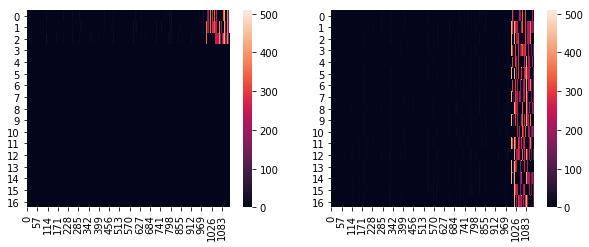

In [51]:
for i in range(features.shape[0]):
    plt.subplot(2,2,i+1)
    sns.heatmap(features[i])

In [61]:
img_feat = features[:,:,:1000]
img_feat.min(), img_feat.max()

(tensor(0.), tensor(48.1306))

In [62]:
audio_feat = features[:,:,1000:]
audio_feat.min(), audio_feat.max()

(tensor(0.), tensor(510.))

# Vocab set

In [ ]:
## pre-build vocab
dataset_folder = os.path.join("../datasets", "MSVD")
train_captions_file = os.path.join(dataset_folder, "metadata", "train.csv")
val_captions_file = os.path.join(dataset_folder, "metadata", "val.csv")
train_captions = pd.read_csv(train_captions_file)["Description"].tolist()
val_captions = pd.read_csv(val_captions_file)["Description"].tolist()
vocab_path = os.path.join(dataset_folder, "metadata", "vocab.pkl")

Vocabulary.prebuild(train_captions + val_captions, vocab_path)

In [ ]:
vocab = Vocabulary.load(vocab_path)
len(vocab)

# Training loop

In [5]:
import argparse
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from tqdm import tqdm

from get_loader import Vocabulary, get_loader
from losses import (EntropyLoss, GlobalReconstructionLoss,
                    LocalReconstructionLoss, TotalReconstructionLoss)

In [6]:
from models.features_captioning import FeaturesCaptioning
from trainer import Trainer

In [7]:
dataset_folder = os.path.join("../datasets", "MSVD")
vocab_pkl = os.path.join(dataset_folder, "metadata", "vocab.pkl")
tiny_loader, tiny_dataset = get_loader(root_dir=dataset_folder, split="tiny", vocab_pkl=vocab_pkl)

Loading Vocab: ../datasets/MSVD/metadata/vocab.pkl 


In [8]:
vocab = Vocabulary.load(vocab_pkl)
print(len(vocab))

3201


In [70]:
decoder_config = {    
    'rnn_type'       : 'LSTM', # ['LSTM', 'GRU']
    'rnn_num_layers' : 1,
    'rnn_birectional': False,  # Bool
    'rnn_hidden_size': 512,
    'rnn_dropout'    : 0.5,    
    
    'in_feature_size': 1000+128,
    'embedding_size' : 128,
    'attn_size'      : 128,
    'output_size'    : 3201, #Vocab Size

    'rnn_teacher_forcing_ratio' : 1.0,
    'max_caption_len' : 30,
}

In [71]:
constructor_config = {   
    'type'           : 'local',  # ['global', 'local']
    'rnn_type'       : 'LSTM',    # ['LSTM', 'GRU']
    'rnn_num_layers' : 1,
    'rnn_birectional': False,     # Bool
    'hidden_size'    : 512,       # feature_size
    'rnn_dropout'    : 0.5,    
    'decoder_size'   : 128,       # decoder_hidden_size
    'attn_size'      : 128,       # only applied for local
}

In [88]:
from models.features_captioning import FeaturesCaptioning
from models.reconstructor import GlobalReconstructor, LocalReconstructor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = decoder_config.copy()
config['output_size'] = len(vocab)
model = FeaturesCaptioning(**config)
model.to(device)

rec_config = constructor_config.copy()
rec_config['decoder_size'] = config['rnn_hidden_size']
rec_config['hidden_size'] = config['in_feature_size']
# reconstructor = GlobalReconstructor(**rec_config,device=device)
reconstructor = LocalReconstructor(**rec_config,device=device)
reconstructor = reconstructor.to(device)

print("Start training")
tr = Trainer(checkpoint_name=os.path.join("checkpoints", "test.ckpt"))
tr.fit(
    model,
    reconstructor,
    tiny_loader,
    tiny_loader,
    device,
    epochs=1,
)


TRAIN:   0%|          | 0/4 [00:00<?, ?it/s]

Start training

Epoch 1/1:


TEST : 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, total=7.87, ce=7.87, e=2.58e+3, recon=1.89e+3]


Validation loss improved from 1000000.0 to 7.840059161186218.
Saving checkpoint to: checkpoints/test.ckpt


{'train_loss': [{'total': 8.017806887626648,
   'ce': 8.017806887626648,
   'e': 4101.0902099609375,
   'recon': 1813.4128112792969}],
 'val_loss': [{'total': 7.840059161186218,
   'ce': 7.840059161186218,
   'e': 4229.341003417969,
   'recon': 1956.0495910644531}],
 'test_loss': []}

In [73]:
data = iter(tiny_loader).next()
x,y = data
x.shape, y.shape

(torch.Size([32, 44, 1128]), torch.Size([15, 32]))

In [74]:
outputs, hidden = model.decode(x,y,max_caption_len=y.shape[0])
outputs.shape, hidden.shape

(torch.Size([15, 32, 3201]), torch.Size([15, 1, 32, 512]))

In [75]:
feat_rec = reconstructor.reconstruct(hidden, outputs, y)
feat_rec.shape

torch.Size([32, 15, 1128])

In [77]:
LocalReconstructionLoss(x, feat_rec)

../losses.py:31: UserWarning: Using a target size (torch.Size([32, 15, 1128])) that is different to the input size (torch.Size([32, 44, 1128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(x, x_recon)


RuntimeError: The size of tensor a (44) must match the size of tensor b (15) at non-singleton dimension 1

In [76]:
x.shape, feat_rec.shape, y.shape

(torch.Size([32, 44, 1128]), torch.Size([32, 15, 1128]), torch.Size([15, 32]))

In [56]:
x_recon = feat_rec
keep_mask = y != 0
xx = x.mean(dim=1)

x_recon.shape, xx.shape

(torch.Size([32, 18, 1128]), torch.Size([32, 1128]))

In [57]:
caption_len = keep_mask.sum(dim=0)
caption_len = caption_len.unsqueeze(1).expand(caption_len.size(0), x_recon.size(2))

caption_len.shape

torch.Size([32, 1128])

In [58]:
y.shape, keep_mask.shape

(torch.Size([18, 32]), torch.Size([18, 32]))

In [61]:
keep_mask = y != 0
keep_mask = keep_mask.transpose(0, 1).unsqueeze(2).expand_as(x_recon)
keep_mask.shape

torch.Size([32, 18, 1128])

In [62]:
caption_len = caption_len.type(torch.FloatTensor).to(x_recon.device)
keep_mask = keep_mask.type(torch.FloatTensor).to(x_recon.device)

x_recon = keep_mask * x_recon
x_recon = x_recon.sum(dim=1) / caption_len

F.mse_loss(xx, x_recon)

tensor(229.8353, grad_fn=<MeanBackward0>)

In [32]:
## load config
decoder_config = {
    'rnn_num_layers' : 1,
    'rnn_bidirection': False,
    'rnn_hidden_size': 512,
    'rnn_attn_size'  : 256,
    'rnn_dropout'    : 0.5, 
    
    #     rnn_type = 'LSTM'; assert rnn_type in [ 'LSTM', 'GRU' ]
    #     rnn_teacher_forcing_ratio = 1.0
}

## load dataset
dataloader = tiny_loader

## load model
## tensor board

## optimizer
## lr_scheduler

## loop
## train 
## val - keep best

## Test

In [ ]:
 decoder = Decoder(
        rnn_type=C.decoder.rnn_type,
        num_layers=C.decoder.rnn_num_layers,
        num_directions=C.decoder.rnn_num_directions,
        feat_size=C.feat.size,
        feat_len=C.loader.frame_sample_len,
        embedding_size=C.vocab.embedding_size,
        hidden_size=C.decoder.rnn_hidden_size,
        attn_size=C.decoder.rnn_attn_size,
        output_size=vocab.n_vocabs,
        rnn_dropout=C.decoder.rnn_dropout)

model = CaptionGenerator(decoder, reconstructor, C.loader.max_caption_len, vocab)
model.cuda()
return model

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Decoder(nn.Module):
    def __init__(self, 
#                  rnn_type = 'LSTM', 
                 rnn_num_layers = 1, 
                 rnn_bidirection = False, 
                 rnn_in_size,
                 embedding_size
                 attn_size
                 hidden_size, , output_size, rnn_dropout):
        super(Decoder, self).__init__()
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.num_directions = num_directions
        self.feat_size = feat_size
        self.feat_len = feat_len
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.attn_size = attn_size
        self.output_size = output_size
        self.rnn_dropout_p = rnn_dropout

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)

        self.attention = TemporalAttention(
            hidden_size=self.num_directions * self.hidden_size,
            feat_size=self.feat_size,
            bottleneck_size=self.attn_size)

        RNN = nn.LSTM if self.rnn_type == 'LSTM' else nn.GRU
        self.rnn = RNN(
            input_size=self.embedding_size + self.feat_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.rnn_dropout_p,
            bidirectional=True if self.num_directions == 2 else False)

        self.out = nn.Linear(self.num_directions * self.hidden_size, self.output_size)

    def get_last_hidden(self, hidden):
        last_hidden = hidden[0] if isinstance(hidden, tuple) else hidden
        last_hidden = last_hidden.view(self.num_layers, self.num_directions, last_hidden.size(1), last_hidden.size(2))
        last_hidden = last_hidden.transpose(2, 1).contiguous()
        last_hidden = last_hidden.view(self.num_layers, last_hidden.size(1), self.num_directions * last_hidden.size(3))
        last_hidden = last_hidden[-1]
        return last_hidden

    def forward(self, input, hidden, feats):
        embedded = self.embedding(input)

        last_hidden = self.get_last_hidden(hidden)
        feats, attn_weights = self.attention(last_hidden, feats)

        input_combined = torch.cat((
            embedded,
            feats.unsqueeze(0)), dim=2)
        output, hidden = self.rnn(input_combined, hidden)

        output = output.squeeze(0)
        output = self.out(output)
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights



In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_CNN = False

In [27]:
features, captions = iter(dataloader).next()

In [28]:
features.shape, captions.shape

(torch.Size([32, 44, 1128]), torch.Size([15, 32]))

In [9]:
captions

tensor([[ 1,  1,  1,  1],
        [ 8,  4,  4,  4],
        [18,  7,  7,  7],
        [ 5,  5,  5,  9],
        [ 3, 25,  3,  3],
        [ 8,  3,  6,  5],
        [ 3, 24,  2,  3],
        [ 2,  3,  0,  6],
        [ 0,  6,  0,  2],
        [ 0,  2,  0,  0]])